In [1]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Loading dataset from Hugging Face and converting it to a pandas DataFrame
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Converting the 'job_posted_date' column to datetime format
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Converting 'job_skills' string representations of lists into actual Python lists
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
# Setting the target country for job analysis
v_job_country = 'India'

# Setting the target job title for skill and salary analysis
v_job_title = 'Data Scientist'

# Defining the minimum skill percentage threshold to filter top skills
v_top_skills_perc = 10

In [3]:
# Filtering the dataset for the selected job title and country
df_DS_Ind = df[(df['job_country'] == v_job_country) & (df['job_title_short'] == v_job_title)].copy()

# Removing rows where the salary information is missing
df_DS_Ind_cleaned = df_DS_Ind.dropna(subset=['salary_year_avg'])

# Exploding the list of skills so each skill appears in its own row
df_DS_Ind_cleaned_explode = df_DS_Ind_cleaned.explode('job_skills')

In [4]:
# Grouping the exploded DataFrame by each skill to get count and median salary
df_DS_skills = df_DS_Ind_cleaned_explode.groupby('job_skills').agg(
    skill_count = ('job_skills', 'count'),                  # Number of times each skill appears
    median_salary = ('salary_year_avg', 'median')           # Median salary for each skill
).sort_values(by='skill_count', ascending=False)            # Sorting by most common skills

# Calculating the total number of data science job postings
DS_job_count = len(df_DS_Ind_cleaned)

# Calculating the percentage of jobs that require each skill
df_DS_skills['skill_perc'] = 100 * (df_DS_skills['skill_count'] / DS_job_count)


In [5]:
# Copying the 'job_type_skills' column from the main DataFrame
df_technology = df['job_type_skills'].copy()

# Removing duplicate entries
df_technology = df_technology.drop_duplicates()

# Dropping any missing (NaN) values
df_technology = df_technology.dropna()

# Initializing an empty dictionary to store technologies and their associated skills
technology_dict = {}

# Iterating through each row (JSON-like string), converting to dictionary
for row in df_technology:
    row_dict = ast.literal_eval(row)  # Safely evaluating the string as a dictionary

    # Aggregating skills under each technology key
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value  # Append skills to existing list
        else:
            technology_dict[key] = value   # Initialize with new list of skills

# Removing duplicate skills within each technology
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [6]:
# Converting the technology-skill dictionary into a DataFrame with 'technology' and corresponding 'skills' columns
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

# Exploding the list of skills so that each skill gets its own row (one-to-many relationship)
df_technology_explode = df_technology.explode('skills')

In [7]:
# Merging skill percentage data with exploded technology data on 'skills'
df_DS_skills_perc = df_DS_skills.merge(df_technology_explode, how='left', left_on='job_skills', right_on='skills')

# Filtering to keep only the skills that are above the defined percentage threshold
df_DS_skills_perc = df_DS_skills_perc[df_DS_skills_perc['skill_perc'] >= v_top_skills_perc]

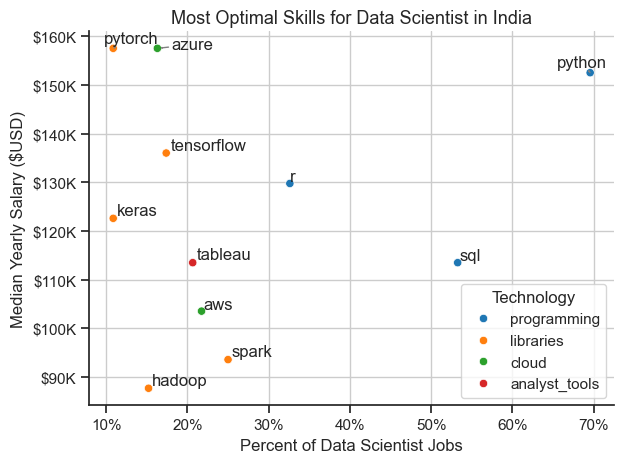

In [9]:
# Importing Additional Libraries
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

# Plotting Scatter Plot
sns.scatterplot(data = df_DS_skills_perc,
                x = 'skill_perc',
                y = 'median_salary',
                hue = 'technology',
                palette = 'tab10')

sns.set_theme(style='ticks')
sns.despine()

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DS_skills_perc['skills']):
    texts.append(plt.text(df_DS_skills_perc['skill_perc'].iloc[i], df_DS_skills_perc['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=1))

# Adjust x and y labels
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter())
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"${int(y/1000)}K"))

# Set legend
plt.legend(title='Technology')

# Set axis labels and title
plt.title(f"Most Optimal Skills for {v_job_title} in {v_job_country}", fontsize=13)
plt.xlabel(f'Percent of {v_job_title} Jobs')
plt.ylabel('Median Yearly Salary ($USD)')

# Add Grid, adjust layout and display plot 
plt.grid()
plt.tight_layout()
plt.show()